In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import time

df = pd.read_csv("data/one_10000.csv") #### read csv file from generate_one_noise.py or generate_one_no_noise.py
encoder = OneHotEncoder(sparse_output=False)
device_type_encoded = encoder.fit_transform(df[['device_type']])
features = [
    'rssi_sdr_1', 'rssi_sdr_2', 'rssi_sdr_3',
    'arrival_time_sdr_1', 'arrival_time_sdr_2', 'arrival_time_sdr_3',
    'center_freq_hz', 'packet_length_bytes'
]

In [29]:
X = np.hstack([df[features].values, device_type_encoded])
Y = df[['device_x', 'device_y', 'device_z']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

In [30]:
class RFLocalizer(nn.Module):
    def __init__(self, input_dim):
        super(RFLocalizer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.net(x)

In [31]:
import matplotlib.gridspec as gridspec

In [32]:
tv_corners = [
    (1.0, 5.0, 1.0),    # bottom-left
    (2.45, 5.0, 1.0),   # bottom-right
    (2.45, 5.0, 1.85),  # top-right
    (1.0, 5.0, 1.85),   # top-left
    (1.0, 5.0, 1.0)     # close the loop
]

In [34]:
model = RFLocalizer(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch = 10
losses = []

#### There are three rows are visualizations. The first row is 3D view of Predictions from All Samples and Mean Prediction. The second row is XY, YZ, XZ planes of Predictions of All Samples. The third row is the planes of Mean Prediction

In [ ]:
loss_list, mse_list, mae_list, rmse_list, acc_list = [], [], [], [], []
threshold = 0.5

for epoch in range(0, epochs, batch):
    for _ in range(batch):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, Y_train_t)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
   
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy()

    pred_mean = preds.mean(axis=0)
    true_mean = Y_test.mean(axis=0)

    mse = mean_squared_error(Y_test, preds)
    mae = mean_absolute_error(Y_test, preds)
    rmse = mse ** 0.5
    loss_list.append(loss.item())
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)

    distances = np.linalg.norm(Y_test - preds, axis=1)
    accuracy = np.mean(distances < threshold)
    acc_list.append(accuracy)

    clear_output(wait=True)
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 4, figure=fig, height_ratios=[2.2, 1.0, 1.0])

    # Row 1 — 3D Views
    ax_3d_all = fig.add_subplot(gs[0, :2], projection='3d')
    ax_3d_mean = fig.add_subplot(gs[0, 2:], projection='3d')
    fig.add_subplot(gs[0, 2]).axis('off')  

    # Row 2 — Plane Projections (All samples)
    ax_xy_all = fig.add_subplot(gs[1, 0])
    ax_xz_all = fig.add_subplot(gs[1, 1])
    ax_yz_all = fig.add_subplot(gs[1, 2])
    # XY plane
    ax_xy_all.set_xlim([0, 5])
    ax_xy_all.set_ylim([0, 5])
    ax_xy_all.set_title("XY Plane — All Predictions")
    ax_xy_all.grid(True)
    # XZ plane
    ax_xz_all.set_xlim([0, 5])
    ax_xz_all.set_ylim([0, 2.5])
    ax_xz_all.set_title("XZ Plane — All Predictions")
    ax_xz_all.grid(True)
    # YZ plane
    ax_yz_all.set_xlim([0, 5])
    ax_yz_all.set_ylim([0, 2.5])
    ax_yz_all.set_title("YZ Plane — All Predictions")
    ax_yz_all.grid(True)

    # Row 3 — Plane Projections (Mean)
    ax_xy_mean = fig.add_subplot(gs[2, 0])
    ax_xz_mean = fig.add_subplot(gs[2, 1])
    ax_yz_mean = fig.add_subplot(gs[2, 2])
    # XY Plane
    ax_xy_mean.set_xlim([0, 5])
    ax_xy_mean.set_ylim([0, 5])
    ax_xy_mean.set_title("XY Plane — Meaan Predictions")
    ax_xy_mean.grid(True)
    # XZ Plane
    ax_xz_mean.set_xlim([0, 5])
    ax_xz_mean.set_ylim([0, 2.5])
    ax_xz_all.set_title("XZ Plane — Mean Predictions")
    ax_xz_mean.grid(True)
    #YZ Plane
    ax_yz_mean.set_xlim([0, 5])
    ax_yz_mean.set_ylim([0, 2.5])
    ax_yz_all.set_title("YZ Plane — Mean Predictions")
    ax_yz_mean.grid(True)

    #All sample 3D
    for i in range(len(tv_corners)-1):
        x, y, z = zip(tv_corners[i], tv_corners[i+1])
        ax_3d_all.plot(x, y, z, color='gray')
    ax_3d_all.scatter(preds[:, 0], preds[:, 1], preds[:, 2], color='red', alpha=0.01, label='All Predictions')
    ax_3d_all.scatter(*true_mean, color='green', s=120, label='Ground Truth')
    for x, y, z in [(1.0, 5.0, 1.0), (2.45, 5.0, 1.0), (2.45, 5.0, 1.85)]:
        ax_3d_all.scatter(x, y, z, color='blue', s=100, marker='^')

    ax_3d_all.set_title("3D — All Predictions")
    ax_3d_all.set_xlim([0, 5]); ax_3d_all.set_ylim([0, 5]); ax_3d_all.set_zlim([0, 2.5])

    #Mean 3D
    for i in range(len(tv_corners)-1):
        x, y, z = zip(tv_corners[i], tv_corners[i+1])
        ax_3d_mean.plot(x, y, z, color='gray')
    ax_3d_mean.scatter(*pred_mean, color='blue', s=120, alpha=0.5, label='Mean Prediction')
    ax_3d_mean.scatter(*true_mean, color='green', s=120, alpha=0.5, label='Ground Truth')
    for x, y, z in [(1.0, 5.0, 1.0), (2.45, 5.0, 1.0), (2.45, 5.0, 1.85)]:
        ax_3d_mean.scatter(x, y, z, color='blue', s=100, marker='^')

    ax_3d_mean.set_title("3D — Mean Prediction")
    ax_3d_mean.set_xlim([0, 5]); ax_3d_mean.set_ylim([0, 5]); ax_3d_mean.set_zlim([0, 2.5])


    # All samples
    ax_xy_all.scatter(preds[:, 0], preds[:, 1], color='red', alpha=0.01)
    ax_xz_all.scatter(preds[:, 0], preds[:, 2], color='red', alpha=0.01)
    ax_yz_all.scatter(preds[:, 1], preds[:, 2], color='red', alpha=0.01)

    # Mean
    ax_xy_mean.scatter(pred_mean[0], pred_mean[1], color='blue', alpha=0.7)
    ax_xz_mean.scatter(pred_mean[0], pred_mean[2], color='blue', alpha=0.7)
    ax_yz_mean.scatter(pred_mean[1], pred_mean[2], color='blue', alpha=0.7)

    # Ground truth coordinates for all planes
    ax_xy_all.scatter(true_mean[0], true_mean[1], color='green')
    ax_xz_all.scatter(true_mean[0], true_mean[2], color='green')
    ax_yz_all.scatter(true_mean[1], true_mean[2], color='green')
    ax_xy_mean.scatter(true_mean[0], true_mean[1], color='green', alpha=0.7)
    ax_xz_mean.scatter(true_mean[0], true_mean[2], color='green', alpha=0.7)
    ax_yz_mean.scatter(true_mean[1], true_mean[2], color='green', alpha=0.7)

    dist = np.linalg.norm(pred_mean - true_mean)
    # Print the metrics for every 10 epochs
    plt.suptitle(f"Epoch {epoch+batch} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Accuracy: {accuracy:.4f}\n"
                f"Ground Truth:{true_mean.round(4)} | Prediction: {pred_mean.round(4)} | Distance Error: {dist:.4f} m", fontsize=25)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"frames/frame_{epoch+batch:04d}.png") #save the frame pic for every 10 epochs
    plt.close()

#### Run 
ffmpeg -framerate 5 -pattern_type glob -i 'frames/frame_*.png' -c:v libx264 -pix_fmt yuv420p frame.mp4

In [ ]:
epoch_steps = list(range(batch, epochs + 1, batch))
metrics_df = pd.DataFrame({
    "Epoch": epoch_steps,
    "Loss": loss_list,
    "MSE": mse_list,
    "MAE": mae_list,
    "RMSE": rmse_list,
    "Accuracy": acc_list
})

print(metrics_df.round(4).to_string(index=False))
metrics_df.to_csv("metrics.csv", index=False) #sacve the metrics dataframe as csv file

 Epoch   Loss    MSE    MAE   RMSE  Accuracy
    10 2.0094 1.8513 1.1506 1.3606    0.0000
    20 0.9489 0.7996 0.7126 0.8942    0.0000
    30 0.3050 0.2331 0.3652 0.4828    0.1333
    40 0.1860 0.1693 0.2954 0.4114    0.4667
    50 0.1658 0.1451 0.2819 0.3809    0.4667
    60 0.1279 0.1069 0.2395 0.3270    0.5333
    70 0.1175 0.1000 0.2328 0.3163    0.5833
    80 0.1059 0.0954 0.2229 0.3089    0.6500
    90 0.0971 0.0935 0.2181 0.3057    0.6167
   100 0.0894 0.0906 0.2126 0.3010    0.6167
   110 0.0825 0.0877 0.2086 0.2961    0.6333
   120 0.0764 0.0853 0.2040 0.2921    0.6500
   130 0.0708 0.0835 0.1996 0.2889    0.6667
   140 0.0658 0.0814 0.1953 0.2853    0.7167
   150 0.0611 0.0792 0.1911 0.2814    0.7167
   160 0.0569 0.0771 0.1873 0.2777    0.7333
   170 0.0530 0.0751 0.1838 0.2740    0.7333
   180 0.0495 0.0730 0.1802 0.2702    0.7500
   190 0.0461 0.0710 0.1769 0.2664    0.7667
   200 0.0430 0.0689 0.1737 0.2625    0.7833
   210 0.0401 0.0668 0.1707 0.2585    0.7833
   220 0.0

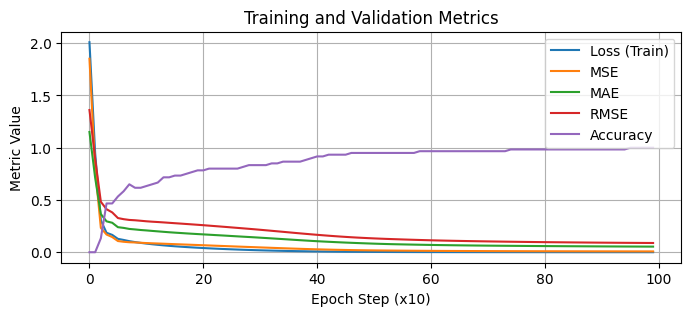

In [ ]:
#Plot metrics
plt.figure(figsize=(8, 3))
plt.plot(loss_list, label='Loss (Train)')
plt.plot(mse_list, label='MSE')
plt.plot(mae_list, label='MAE')
plt.plot(rmse_list, label='RMSE')
plt.plot(acc_list, label='Accuracy')
plt.xlabel("Epoch Step (x10)")
plt.ylabel("Metric Value")
plt.title("Training and Validation Metrics")
plt.grid()
plt.legend()
plt.show()